<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1">Setup</a></span></li><li><span><a href="#Spectral-clustering" data-toc-modified-id="Spectral-clustering-2">Spectral clustering</a></span><ul class="toc-item"><li><span><a href="#K-Means" data-toc-modified-id="K-Means-2.1">K-Means</a></span></li><li><span><a href="#Load-and-clean-the-data" data-toc-modified-id="Load-and-clean-the-data-2.2">Load and clean the data</a></span></li><li><span><a href="#Form-L,-D,-and-A" data-toc-modified-id="Form-L,-D,-and-A-2.3">Form L, D, and A</a></span></li><li><span><a href="#Compute-eigenvectors-of-L" data-toc-modified-id="Compute-eigenvectors-of-L-2.4">Compute eigenvectors of L</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3">PCA</a></span><ul class="toc-item"><li><span><a href="#Load-and-clean-the-data" data-toc-modified-id="Load-and-clean-the-data-3.1">Load and clean the data</a></span></li><li><span><a href="#Standardize-the-data" data-toc-modified-id="Standardize-the-data-3.2">Standardize the data</a></span></li><li><span><a href="#Compute-covariance-matrix-$C$" data-toc-modified-id="Compute-covariance-matrix-$C$-3.3">Compute covariance matrix $C$</a></span></li><li><span><a href="#Compute-and-plot-top-2-eigenvectors-of-$C$" data-toc-modified-id="Compute-and-plot-top-2-eigenvectors-of-$C$-3.4">Compute and plot top 2 eigenvectors of $C$</a></span></li><li><span><a href="#Compute-and-plot-reduced-representation-of-data" data-toc-modified-id="Compute-and-plot-reduced-representation-of-data-3.5">Compute and plot reduced representation of data</a></span></li></ul></li></ul></div>

# Setup

In [1]:
# Imports
import numpy as np
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt
from scipy.spatial import distance
from sklearn.cluster import KMeans
import random
import math

# Spectral clustering
This section contains code implementing spectral clustering.

## K-Means
This section contains code defining a k-means algorithm to use in spectral clustering.

In [2]:
def kmeans(K, data, starting_centroids=None, max_steps=np.inf):
    if starting_centroids is None:
        # Randomly select K points from the data as cluster representatives.
        unique_points = np.unique(data, axis=0)
        centroids = unique_points[np.random.choice(unique_points.shape[0], K, replace=False)]
    else:
        assert(starting_centroids.shape[0] == K and starting_centroids.shape[1] == data.shape[1])  # Verify that shape is OK
        centroids = starting_centroids
    
    N, d = data.shape
    
    converged = False
    labels = np.zeros(len(data))
    iteration = 1
    
    while (not converged) and (iteration <= max_steps):
        old_centroids = centroids

        # Calculate dissimilarities using squared Euclidean distance (squared L2 norm)
        dissimilarities = distance.cdist(data, old_centroids, metric='sqeuclidean')

        # Assign labels
        labels = np.argmin(dissimilarities, axis=1)  # Return index of minimum dissimilarity by row 

        # Update centroids
        centroids = np.empty((K, d))

        for k in range(K):
            # Filter the labels array (identify indices where the label == current cluster k)
            # Filter the data array by those indices and take the mean by column (axis 0)
            centroids[k, :] = np.mean(data[labels == k], axis=0)

        # Check for convergence
        converged = set([tuple(ctr) for ctr in old_centroids]) == set([tuple(ctr) for ctr in centroids])

        iteration += 1

    return labels, centroids

## Load and clean the data
The input data has a few issues that will complicate spectral clustering:

* There is a small connected component of only two nodes
* The edges file is not truly undirected; there are nodes in only one direction in some cases
* There are nodes with edges to themselves
* There are isolated nodes (nodes unconnected to the rest of the network)

This section contains code to clean up the data for use in spectral clustering.

In [3]:
# Read in nodes file
with open('nodes.txt', 'r') as file:
    lines = [line.split() for line in file]
    nodes = np.array(lines)[:, 0].astype(int)
    true_labels = np.array(lines)[:, 2].astype(int)
    
# Read in edges file
with open('edges.txt', 'r') as file:
    lines = [line.split() for line in file]
    edges = np.array(lines).astype(int)

In [4]:
# The edges file is not truly undirected - I need to flip the edges and de-duplicate to get a fully undirected graph
# In test_football.py, this is accomplished by adding the transpose of the adjacency matrix to itself
from_nodes = edges[:, 0]
to_nodes = edges[:, 1]
flipped_edges = np.vstack((to_nodes, from_nodes)).T
undirected = np.concatenate((edges, flipped_edges))
edges = np.unique(undirected, axis=0)
print(edges.shape)

(33433, 2)


In [5]:
# Identify the small cluster of two nodes
i = edges[:, 0]
j = edges[:, 1]

# Get count of occurrences of each node in the edges
i_nodes, i_counts = np.unique(i, return_counts=True)
j_nodes, j_counts = np.unique(j, return_counts=True)

i_single = i_nodes[i_counts == 1]  # All nodes only connected to 1 other node

# Now for each node above, I want to find their corresponding to node
# Find the to node(s) that ALSO only have a degree of 1
i_single_connections = edges[np.searchsorted(edges[:, 0], i_single)][:, 1]  # IDs of to nodes for from nodes w/ degree of 1
print(i_single_connections[j_counts[np.searchsorted(j_nodes, edges[np.searchsorted(edges[:, 0], i_single)][:, 1])] == 1])

[666 182]


In [6]:
# Remove the edges between 666 and 182
edges = np.delete(edges, np.where((edges[:, 0] == 666) | (edges[:, 0] == 182)), axis=0)

In [7]:
# Remove nodes connected to themselves in the edge array
print(edges[np.where(edges[:, 0] == edges[:, 1])])
edges = np.delete(edges, np.where(edges[:, 0] == edges[:, 1]), axis=0)

[[  24   24]
 [1047 1047]
 [1260 1260]]


In [8]:
# Remove unconnected nodes
true_labels = true_labels[np.in1d(nodes, edges)]
nodes = nodes[np.in1d(nodes, edges)]
print(nodes[:5])
print(true_labels[:5])

[1 2 5 6 7]
[0 0 0 0 0]


## Form L, D, and A
In this section, I form the adjacency, degree, and Laplacian matrices.

Because edges and nodes were removed in the prior section, all references need to be re-indexed.

In [9]:
i = edges[:, 0]
j = edges[:, 1]
print(i[:5])
print(j[:5])

[1 1 1 1 1]
[ 2 21 23 55 68]


In [10]:
i = np.searchsorted(nodes, i)
j = np.searchsorted(nodes, j)
print(i[:5])
print(j[:5])

[0 0 0 0 0]
[ 1 18 20 47 56]


In [11]:
m = nodes.shape[0]
v = np.ones((i.shape[0], 1)).flatten()

# Calculate adjacency matrix A
A = sparse.coo_matrix((v, (i, j)), shape=(m, m))

In [12]:
# Calculate degree matrix D^(-1/2) in order to calculate the normalized graph Laplacian
D = np.diag(1 / np.sqrt(np.sum(A, axis=1)).A1)
print(D)

[[0.19611614 0.         0.         ... 0.         0.         0.        ]
 [0.         0.1490712  0.         ... 0.         0.         0.        ]
 [0.         0.         0.5        ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.23570226 0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [13]:
I = np.identity(m)
L = I - (D @ A @ D)  # Calculate normalized Laplacian: I - D^(-1/2) A D^(-1/2)
print(L)

[[ 1.         -0.02923527  0.         ...  0.          0.
   0.        ]
 [-0.02923527  1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.         -0.23570226
   0.        ]
 [ 0.          0.          0.         ... -0.23570226  1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


## Compute eigenvectors of L

In [14]:
v, x = np.linalg.eig(L)

In [15]:
# Sort both in ascending order of eigenvalues
x = x[:, np.argsort(v)].real
v = v[np.argsort(v)]

C:\Users\rthrw\miniconda3\envs\omsa\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


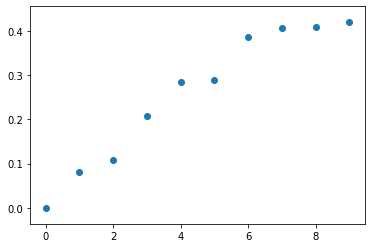

In [16]:
# Plot first 10 eigenvalues
plt.scatter(list(range(10)), v[:10])

The plot above shows that the entire graph is technically one connected component since there is only one zero (or very near-zero) eigenvalue. This is not unexpected for real-life data.

However, the second and third eigenvalue (the Fiedler value) is near zero, indicating that the graph is almost two connected components. Removing a certain edge could result in separation.

Visually, the largest eigengap appears to be between the third and fourth eigenvalues, and then between the sixth and seventh.

<Figure size 432x288 with 0 Axes>

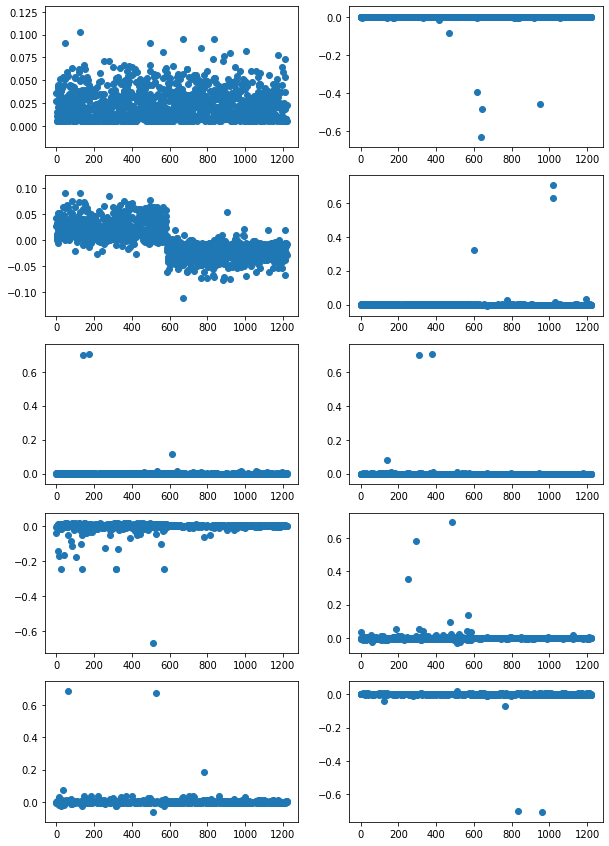

In [17]:
fig = plt.figure()
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10, 15))

plot_order = 0
for i in range(5):
    for j in range(2):
        scatterplot = axes[i][j].scatter(x = np.arange(x.shape[1]), y = x[:, plot_order])
        plot_order += 1

plt.show()

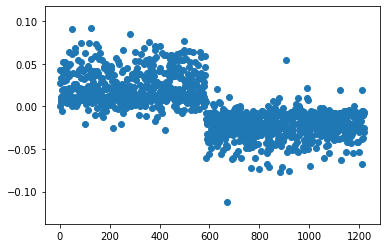

In [18]:
scatterplot = plt.scatter(x = np.arange(x.shape[1]), y = x[:, 2])
plot_order += 1

The above plot indicates that the **third** eigenvector will be useful in achieving cluster separation via k-means, as the graph shows separation between groups of data points.

The code below runs k-means using different sets of eigenvectors: only the first eigenvector, only the first two, etc.

In [19]:
random.seed(503)

for k in range(10):
    clusters, centroids = kmeans(2, x[:, :k+1])  # Take all rows of the first k eigenvectors
    accuracy = nodes[clusters == true_labels].shape[0] / nodes.shape[0]
    accuracy = max(accuracy, 1 - accuracy)
    print(f"first {k+1} eigenvectors: accuracy = {accuracy}")

first 1 eigenvectors: accuracy = 0.5090016366612111
first 2 eigenvectors: accuracy = 0.5090016366612111
first 3 eigenvectors: accuracy = 0.9492635024549918
first 4 eigenvectors: accuracy = 0.8355155482815058
first 5 eigenvectors: accuracy = 0.9484451718494271
first 6 eigenvectors: accuracy = 0.9484451718494271
first 7 eigenvectors: accuracy = 0.9459901800327333
first 8 eigenvectors: accuracy = 0.9459901800327333
first 9 eigenvectors: accuracy = 0.532733224222586
first 10 eigenvectors: accuracy = 0.9402618657937807


As expected, accuracy suffers until I include the third eigenvector.

Note that accuracy above is calculated as $max(accuracy, 1 - accuracy)$. This is because the actual cluster labels assigned by k-means are meaningless unless provided with a set of starting centroids. There is no guarantee that the specific labels will match the original labels. The true goal is to form two separate clusters and assign membership so that similar blogs end up in the same cluster. Therefore, if the majority of blogs with the same true label are assigned to the same cluster, and if that cluster's label does not match the true label (i.e. the cluster label is "wrong"), then $1 - accuracy$ reflects the true accuracy.

# PCA
This section contains code implementing PCA on the food consumption dataset.

The data `food-consumption.csv` contains 16 countries in the European area and their consumption for 20 food items, such as tea, jam, coffee, yoghurt, and others. There are some missing data entries: you may remove the rows "Sweden", "Finland", and "Spain". The goal is to perform PCA analysis on the data, i.e., find a way to perform linear combinations of features across all 20 food-item consumptions, for each country. If we extract two principal components, that means we use two singular vectors that correspond to the largest singular values of the data matrix, in combining features. You will need to implement PCA by writing your own code.

***

## Load and clean the data

In [20]:
# Read in food-consumption.csv
food_df = pd.read_csv('food-consumption.csv')

In [21]:
# Remove Sweden, Finland, Spain
food_df.drop(food_df[food_df["Country"].isin(["Sweden", "Finland", "Spain"])].index, axis=0, inplace=True)

In [22]:
# Reset indices for plotting country names later
food_df.reset_index(drop=True, inplace=True)

In [23]:
display(food_df)

,Country,Real coffee,Instant coffee,Tea,Sweetener,Biscuits,Powder soup,Tin soup,Potatoes,Frozen fish,...,Apples,Oranges,Tinned fruit,Jam,Garlic,Butter,Margarine,Olive oil,Yoghurt,Crisp bread
0,Germany,90,49,88,19.0,57.0,51,19,21,27,...,81,75,44,71,22,91,85,74,30.0,26
1,Italy,82,10,60,2.0,55.0,41,3,2,4,...,67,71,9,46,80,66,24,94,5.0,18
2,France,88,42,63,4.0,76.0,53,11,23,11,...,87,84,40,45,88,94,47,36,57.0,3
3,Holland,96,62,98,32.0,62.0,67,43,7,14,...,83,89,61,81,15,31,97,13,53.0,15
4,Belgium,94,38,48,11.0,74.0,37,23,9,13,...,76,76,42,57,29,84,80,83,20.0,5
5,Luxembourg,97,61,86,28.0,79.0,73,12,7,26,...,85,94,83,20,91,94,94,84,31.0,24
6,England,27,86,99,22.0,91.0,55,76,17,20,...,76,68,89,91,11,95,94,57,11.0,28
7,Portugal,72,26,77,2.0,22.0,34,1,5,20,...,22,51,8,16,89,65,78,92,6.0,9
8,Austria,55,31,61,15.0,29.0,33,1,5,15,...,49,42,14,41,51,51,72,28,13.0,11
9,Switzerland,73,72,85,25.0,31.0,69,10,17,19,...,79,70,46,61,64,82,48,61,48.0,30


In [24]:
# Compute the data matrix
X = food_df.iloc[:, 1:].values
print(X[:2, :])

[[90. 49. 88. 19. 57. 51. 19. 21. 27. 21. 81. 75. 44. 71. 22. 91. 85. 74.
  30. 26.]
 [82. 10. 60.  2. 55. 41.  3.  2.  4.  2. 67. 71.  9. 46. 80. 66. 24. 94.
   5. 18.]]


In [25]:
# Compute the country label array
countries = food_df.iloc[:, 0]
print(countries)

0         Germany
1           Italy
2          France
3         Holland
4         Belgium
5      Luxembourg
6         England
7        Portugal
8         Austria
9     Switzerland
10        Denmark
11         Norway
12        Ireland
Name: Country, dtype: object


In [26]:
attributes = food_df.columns[1:]
print(attributes)

Index(['Real coffee', 'Instant coffee', 'Tea', 'Sweetener', 'Biscuits',
       'Powder soup', 'Tin soup', 'Potatoes', 'Frozen fish', 'Frozen veggies',
       'Apples', 'Oranges', 'Tinned fruit', 'Jam', 'Garlic', 'Butter',
       'Margarine', 'Olive oil', 'Yoghurt', 'Crisp bread'],
      dtype='object')


## Standardize the data

In [27]:
# Standardize the data by calculating the mean of each feature and subtracting it from the column's values
# Then divide by standard eviation
mu = np.mean(X, axis=0)
sd = np.std(X, axis=0)

X_centered = (X - mu)/sd
print(X_centered[:2, :])

[[ 0.5826709   0.25673405  0.49892637  0.20229397 -0.16085813 -0.0410251
   0.03473997  1.44569435  0.62461571  0.59615116  0.64703155  0.31649154
   0.01932229  0.64771389 -0.65284608  0.69479321  0.53205481  0.70687681
   0.40721798  0.32263212]
 [ 0.24223397 -1.50224114 -1.23068505 -1.39438347 -0.25812119 -0.707683
  -0.7681394  -1.30112492 -1.32080196 -1.17793723 -0.14330229  0.03754984
  -1.44595164 -0.46021776  1.09891885 -0.5737899  -1.86521488  1.43909979
  -0.91624044 -0.20164508]]


## Compute covariance matrix $C$

In [28]:
# Compute the covariance matrix as (x_i - mu)(x_i - mu)^T
m, d = X_centered.shape
X_centered = X_centered.T  # Transpose to compute covariance matrix as stated above
C = (X_centered @ X_centered.T)/m
print(C[:2, :])

[[ 1.         -0.39614708 -0.28767679  0.18773245 -0.09348244 -0.17380856
  -0.38342236  0.17888405  0.37476493  0.23368149  0.37159059  0.66111712
  -0.09622466 -0.42281081  0.2383226  -0.20783547  0.33012094  0.12238849
   0.38986262  0.18163516]
 [-0.39614708  1.          0.50519442  0.43716769  0.32424323  0.69491639
   0.69528849  0.28890212 -0.16446845  0.14433066  0.40245155  0.25431472
   0.76730937  0.45825608 -0.13784079  0.24906705  0.16077158 -0.06068527
   0.48299172 -0.10443028]]


## Compute and plot top 2 eigenvectors of $C$

In [29]:
import scipy.sparse.linalg as ll

In [30]:
random.seed(503)
#S, W = ll.eigs(C, k=2, v0=np.ones(20))
S, W = ll.eigs(C, k=2)

In [36]:
W.shape

(20, 2)

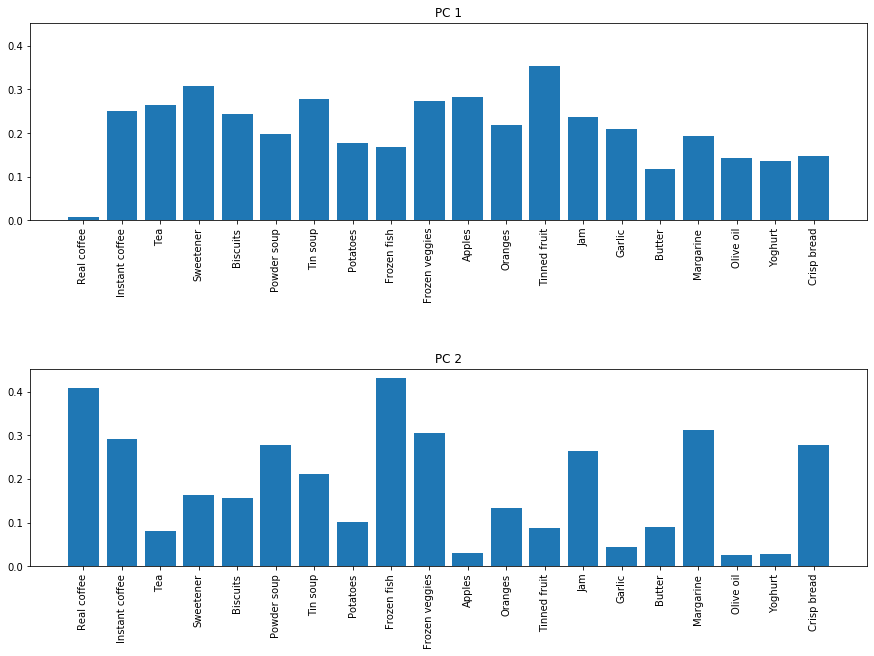

In [31]:
# Plot eigenvectors
fig, axes = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(15, 10))

for k in range(2):
    axes[k].bar(range(d), np.abs(W[:, k]))
    axes[k].set_title(f"PC {k+1}")
    axes[k].set_xticks(range(d))
    axes[k].set_xticklabels(attributes)
    
    for tick in axes[k].get_xticklabels():
        tick.set_rotation(90)
        
plt.subplots_adjust(hspace=0.75)

Above, I have plotted the absolute value of each feature's representation in each principal component. My observations:
* The first principal component's entries with the greatest magnitude correspond to tinned fruit, sweetener, apples, tin soup, and frozen veggies
* The second principal component's entries with the greatest magnitude correspond to frozen fish, real coffee, frozen veggies, and margarine
* PC 1 does not weigh any one entry more than others to the same extent that PC 2 does; the magnitude plot looks smoother and weighs the original dimensions more evenly

## Compute and plot reduced representation of data

In [37]:
X_centered.shape

(20, 13)

In [32]:
pc_1 = np.dot(W[:, 0].real.T, X_centered)/math.sqrt(S[0].real)
pc_2 = np.dot(W[:, 1].real.T, X_centered)/math.sqrt(S[1].real)
print(pc_1)
print(pc_2)

[ 0.57329686 -1.53772092 -0.18998109  1.08418742 -0.33521833  0.75764056
  1.57883577 -1.84723099 -1.25917848  0.29016371  0.90855127  0.05294624
 -0.07629203]
[-0.4621445   0.26636673  0.42897374  0.25175961 -0.0373917  -0.58240696
  1.23112203 -0.38616983 -0.1048437   0.2567335  -1.88222089 -1.26789338
  2.28811535]


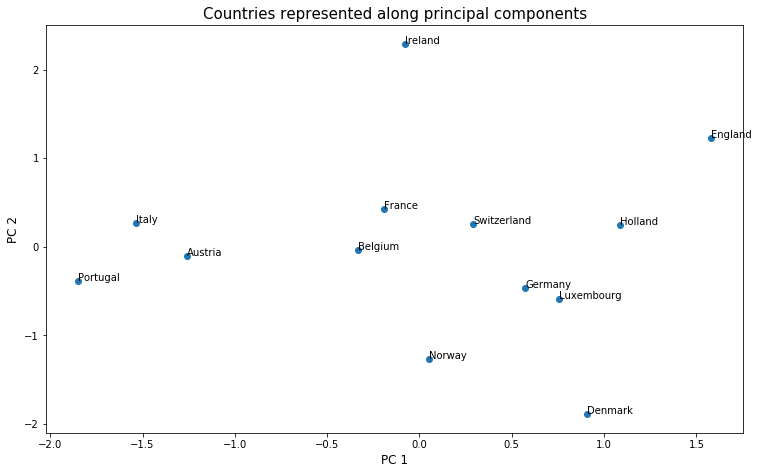

In [33]:
# Plot reduced representation
fig = plt.figure(figsize=(12.5,7.5))
plt.scatter(pc_1, pc_2)

for x, y, country in zip(pc_1, pc_2, countries):
    plt.annotate(country, xy=(x, y))
    plt.title("Countries represented along principal components", fontsize=15)
    plt.xlabel("PC 1", fontsize=12)
    plt.ylabel("PC 2", fontsize=12)

My observations:
* Ireland, Norway, and Denmark all seem to at the extreme ends along the direction of PC 2; examining the standardized data shows that these countries all have more extreme values for the food attributes most strongly represented in PC 2. For example, Ireland is almost 2 standard deviations below the mean in its real coffee and margarine consumption. Denmark is more than 2 standard deviations above the mean in its frozen fish and frozen veggie consumption.
* Countries are more spread out along the direction of PC 1 than PC 2. This makes intuitive sense given the differences between the two principal components; the representation of each original dimension in PC 1 varies less than it does in PC 2, so it captures more of the variation between countries.